In [1]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.stats import skew
import math

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from utils.dataManagers.dataSteward import DataSteward
from utils.dataManagers.informations import informer
from utils.predictions import *
from utils.dataManagers.dataWrangler import *

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from utils.ClassifierResults import TreeResults

ds = DataSteward('mapper_and_most_frequent', 'mean')
column_desc = informer.get_column_descriptions()

train = ds.train_data
test = ds.test_data
ytrain = ds.train_response

In [2]:
number_type = get_number_types(train)

skewness = number_type.apply(lambda x: skew(x))
cols_to_log = skewness[np.abs(skewness.sort_values()) >= .75].index

train_log = log_given_columns(train, cols_to_log)
test_log = log_given_columns(test, cols_to_log)
trainWithDummies, testWithDummies = get_df_for_predictions(train_log, test_log)

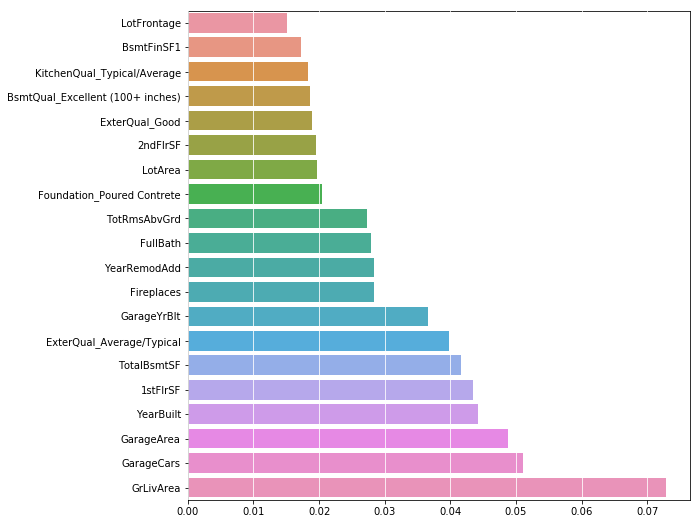

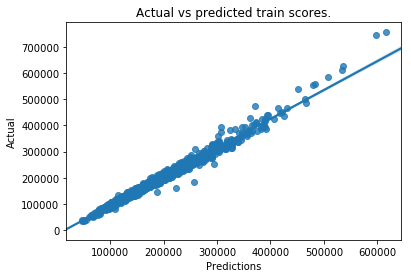

c:\users\matka\anaconda3\lib\site-packages\matplotlib\figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


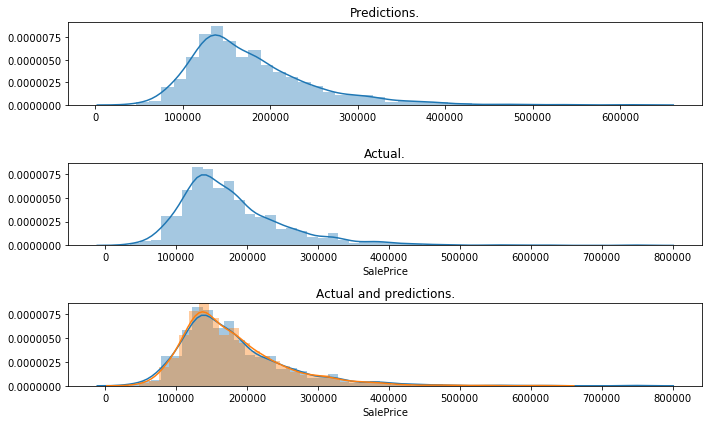

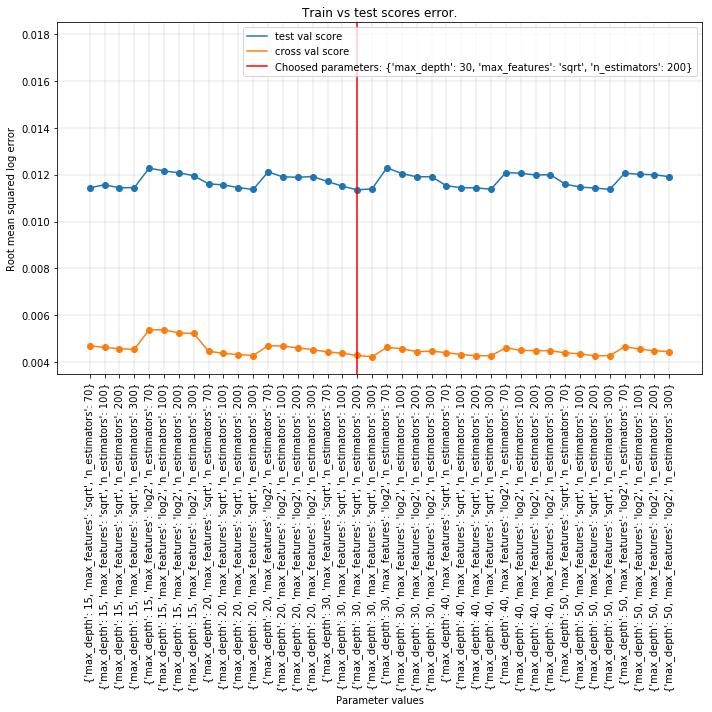

In [3]:
param_grid = {'n_estimators': [70, 100, 200, 300], 'max_depth': [15, 20, 30, 40, 50], 'max_features': ['sqrt', 'log2']}
rf = RandomForestRegressor()
rf_results = predict(TreeResults, rf, param_grid, trainWithDummies,
                        np.log1p(ytrain), testWithDummies, 
                        'first_tree',
                       predictions_form_restoring_method=restore_predictions_from_log1p)

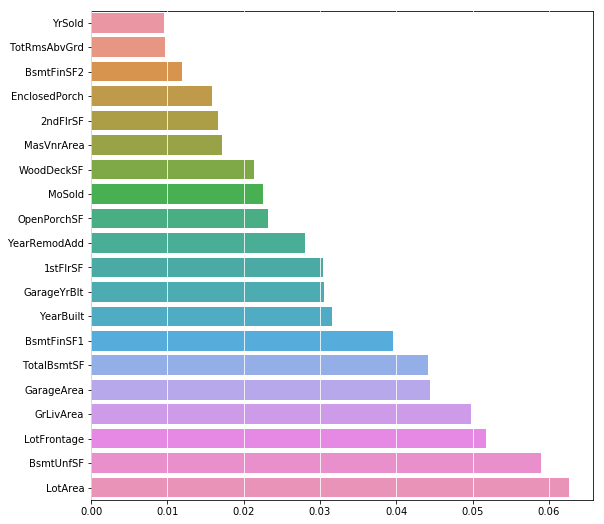

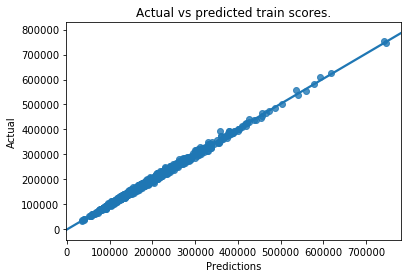

c:\users\matka\anaconda3\lib\site-packages\matplotlib\figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


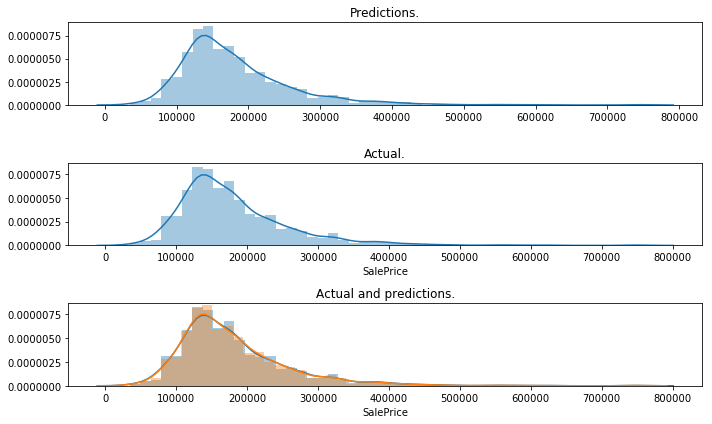

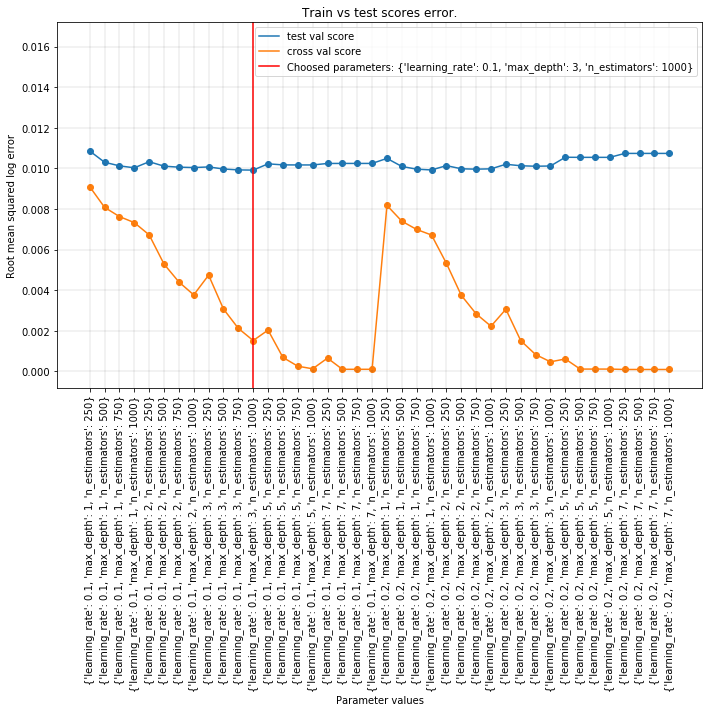

In [27]:
import xgboost as xgb

param_grid = {'learning_rate': [.1, .2,], 'n_estimators': [250, 500, 750, 1000], 'max_depth': [1, 2, 3, 5, 7]}
xgb_model = xgb.XGBRegressor()

xgb_results = predict(TreeResults, xgb_model, param_grid, trainWithDummies,
                        np.log1p(ytrain), testWithDummies, name='xgb',
                       predictions_form_restoring_method=restore_predictions_from_log1p)

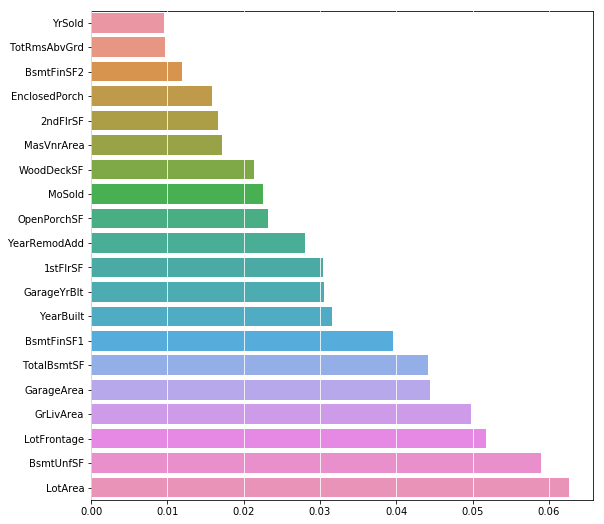

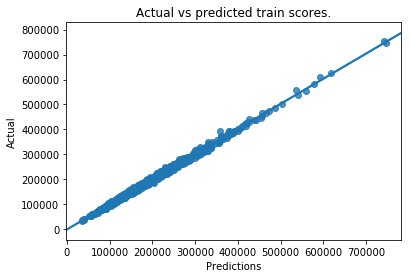

c:\users\matka\anaconda3\lib\site-packages\matplotlib\figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


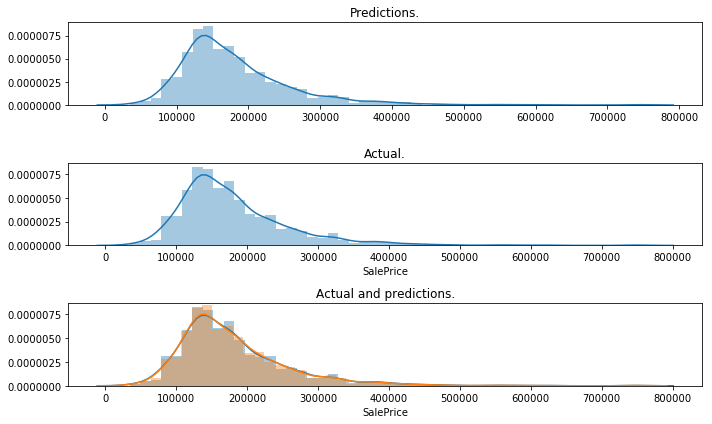

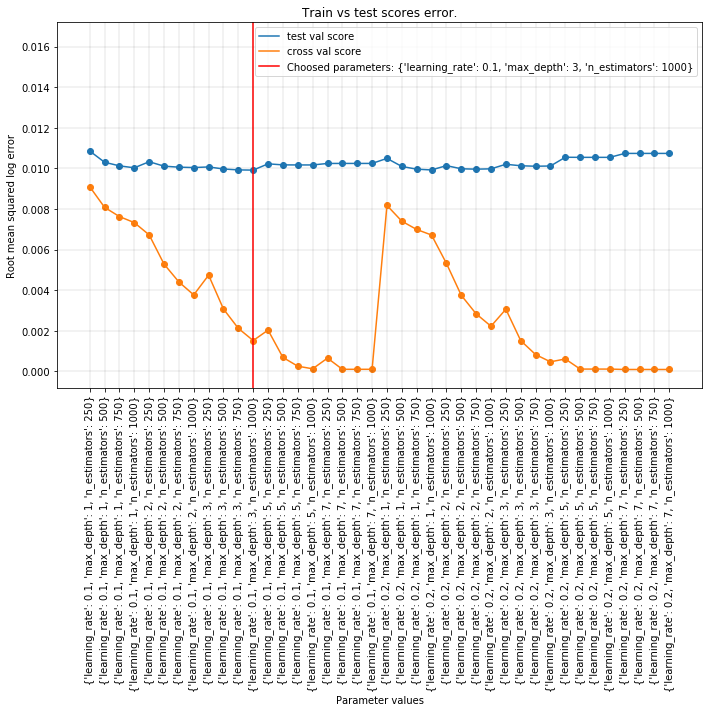

In [30]:
import xgboost as xgb

param_grid = {'learning_rate': [.1, .2,], 'n_estimators': [250, 500, 750, 1000],
              'max_depth': [1, 2, 3, 5, 7]}
xgb_model = xgb.XGBRegressor()

xgb_results = predict(TreeResults, xgb_model, param_grid, trainWithDummies,
                        np.log1p(ytrain), testWithDummies, name='xgb',
                       predictions_form_restoring_method=restore_predictions_from_log1p)

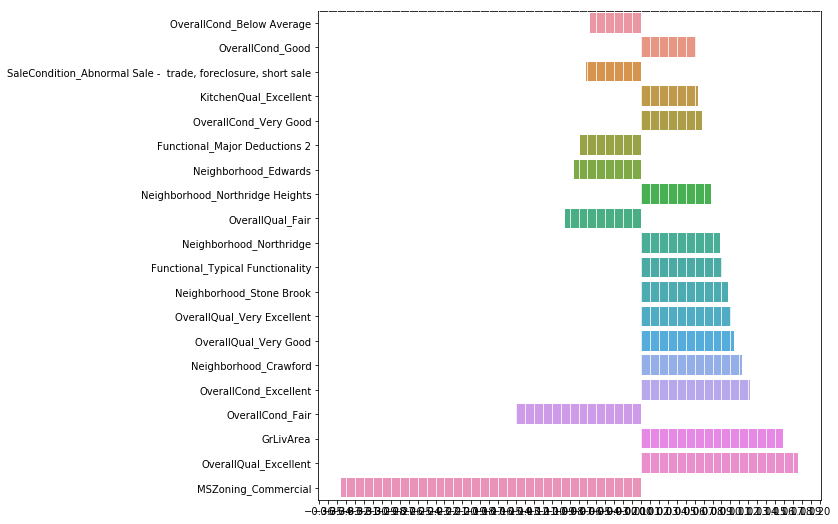

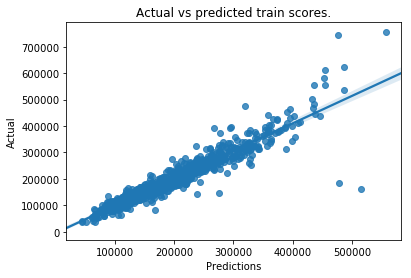

c:\users\matka\anaconda3\lib\site-packages\matplotlib\figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


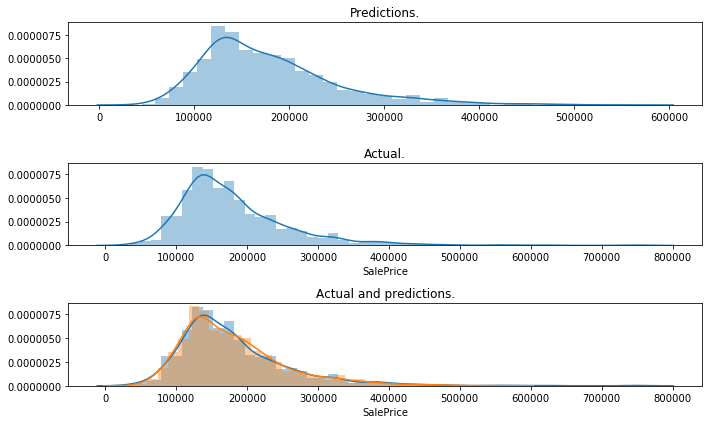

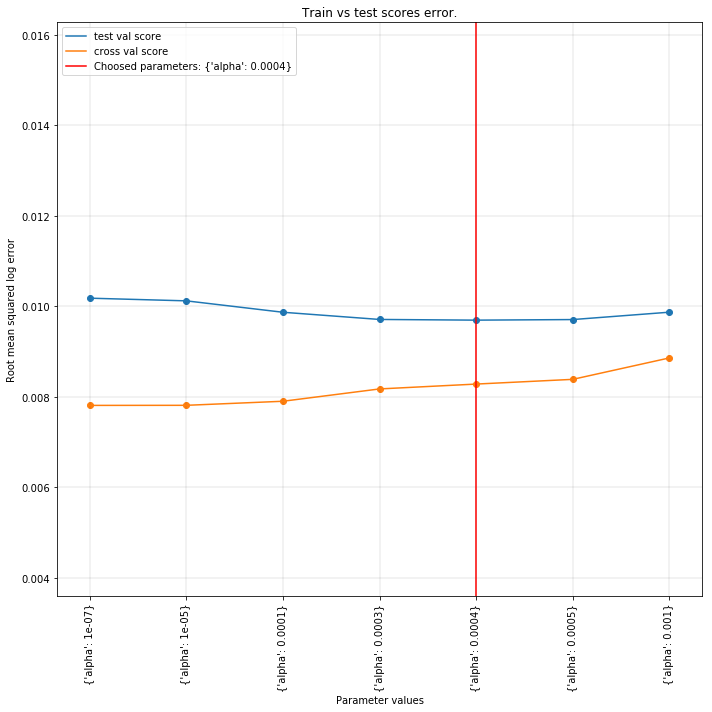

In [42]:
from utils.ClassifierResults import RegressionResults
from sklearn.linear_model import Lasso

alphas = [1e-7, 1e-5, 1e-4, 3e-4, 4e-4, 5e-4, 1e-3]
param_grid = dict(alpha=alphas)

lasso_results = predict(RegressionResults, Lasso(normalize=False, max_iter=5000), param_grid, trainWithDummies,
                        np.log1p(ytrain), testWithDummies, name=None,
                        predictions_form_restoring_method=restore_predictions_from_log1p)

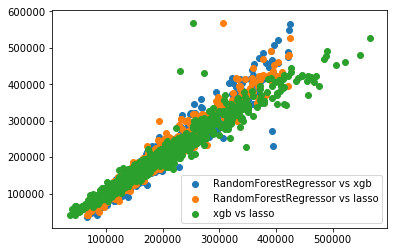

In [51]:
def plot_test_predictions(first, second, label):
    plt.scatter(first, second, label=label)
    
plot_test_predictions(rf_results.test_predictions, xgb_results.test_predictions, label='RandomForestRegressor vs xgb')
plot_test_predictions(rf_results.test_predictions, lasso_results.test_predictions, label='RandomForestRegressor vs lasso')
plot_test_predictions(xgb_results.test_predictions, lasso_results.test_predictions, label='xgb vs lasso')
plt.legend()

In [58]:
def get_predictions(rf_results, xgb_results, lasso_results):
    return .2 * rf_results + .2 * xgb_results + .6 * lasso_results

predictions = get_predictions(rf_results.test_predictions, xgb_results.test_predictions, lasso_results.test_predictions)
predictions.to_csv('scores/ensemble_13186.csv')
predictions.head()

,SalePrice
Id,
1461,121240.490039
1462,151250.828679
1463,188995.256139
1464,195278.171087
1465,197249.370989


In [59]:
def get_predictions(rf_results, xgb_results, lasso_results):
    return .1 * rf_results + .2 * xgb_results + .7 * lasso_results

predictions = get_predictions(rf_results.test_predictions, xgb_results.test_predictions, lasso_results.test_predictions)
predictions.to_csv('scores/ensemble.csv')
predictions.head()

,SalePrice
Id,
1461,120353.786883
1462,151263.335215
1463,189563.690619
1464,196150.369558
1465,198764.068807


In [5]:
# dtrain = xgb.DMatrix(trainWithDummies, label = np.log1p(ytrain))
# dtest = xgb.DMatrix(testWithDummies)

# params = {"max_depth":2, "eta":0.1}
# model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)
# model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [159]:
# model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
# model_xgb.fit(trainWithDummies, np.log1p(ytrain))
# xgb_preds = np.expm1(model_xgb.predict(testWithDummies))

# preds = pd.DataFrame({'xgb': xgb_preds, 'lasso':results.predictions.SalePrice})
# preds.plot(kind='scatter', x='xgb', y='lasso')

# preds.xgb.to_frame(name='SalePrice').to_csv('scores/xgboost.csv')
#0,14249

#0.13447
# weighted_preds = 0.7*preds.lasso + 0.3*preds.xgb
# weighted_preds.head()
# weighted_preds.to_frame(name='SalePrice').to_csv('scores/weighted_preds.csv')

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=360,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)